Computed mean :tensor([-0.0174, -0.0359, -0.1072])
Computed standard deviation :tensor([0.4936, 0.4865, 0.5226])
GPU: Tesla T4 is available.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 1/100 Training Loss: 821396565561.4724 Training Accuracy: 10.184% Testing Accuracy: 9.99%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 2/100 Training Loss: 296025.2477113544 Training Accuracy: 11.718% Testing Accuracy: 10.03%

Epoch 3/100 Training Loss: 221788.7560418102 Training Accuracy: 14.815999999999999% Testing Accuracy: 13.4%

Epoch 4/100 Training Loss: 4635.229356410552 Training Accuracy: 21.044% Testing Accuracy: 17.84%

Epoch 5/100 Training Loss: 1.5346351977513761 Training Accuracy: 44.034% Testing Accuracy: 49.65%

Epoch 6/100 Training Loss: 1.2840343281930806 Training Accuracy: 53.56999999999999% Testing Accuracy: 55.31%

Epoch 7/100 Training Loss: 1.1161796925019245 Training Accuracy: 60.056% Testing Accuracy: 65.42999999999999%

Epoch 8/100 Training Loss: 1.0125173838162909 Training Accuracy: 63.852% Testing Accuracy: 63.959999999999994%

Epoch 9/100 Training Loss: 0.9339865224093807 Training Accuracy: 66.88% Testing Accuracy: 65.61%

Epoch 10/100 Training Loss: 0.8718086301672215 Training Accuracy: 69.226% Testing Accuracy: 68.38%

Epoch 11/100 Training Loss: 0.8201155528730276 Training Accuracy

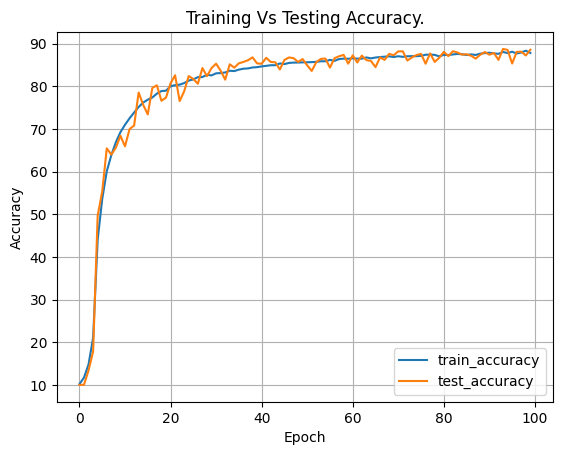

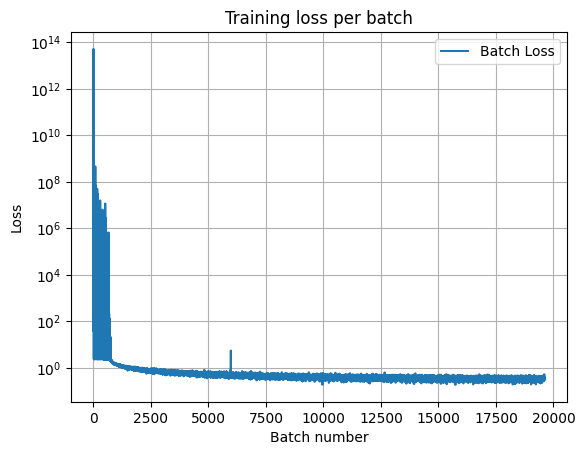

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

size=(32,32)
#data augmentation pipeline to improve the generalisation to unseen data and reduce overfitting.
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



# # Download training set
train_dataset = torchvision.datasets.CIFAR10(root='/Users/tskz48/Library/Mobile Documents/com~apple~CloudDocs/QueenMarysBigDataScience/NeuralNetworksAndDeepLearning', train=True, transform=data_transforms, download=True)

# Download test set
test_dataset = torchvision.datasets.CIFAR10(root='/Users/tskz48/Library/Mobile Documents/com~apple~CloudDocs/QueenMarysBigDataScience/NeuralNetworksAndDeepLearning', train=False, transform=data_transforms, download=True)

#The resolution of cifar10 images are 32x32 and there are RGB images (3 channels) Therefore the dimensions of each image are (3,32,32).



train_loader=DataLoader(train_dataset,batch_size=256,num_workers=4,pin_memory=True,shuffle=True) 
test_loader=DataLoader(test_dataset,batch_size=256,num_workers=4,pin_memory=True,shuffle=False)


total_mean=torch.zeros(3) #initialise empty tensor with zeros to store the means.
total_std=torch.zeros(3) #initialise empty tensor with zeros to store the standard deviations.
for images,_ in train_loader:
  batch_mean = images.mean(dim=[0,2,3]) #the mean for the batch. #we specify [0,2,3] so we calculate the mean for each channel separately.
  batch_std = images.std(dim=[0,2,3]) #the standard deviation of the batch
  total_mean+=batch_mean #add the batch mean to the running total of means across all batches
  total_std+=batch_std #add the batch standard deviation to the running total of standard deviation across all batches

mean=total_mean/len(train_loader) #divide the total of the batch means by the number of batches to get the mean for the entire training set, for each channel.
std=total_std/len(train_loader)#divide the total of the batch standard deviations by the number of batches to get the mean for the entire training set, for each channel.
print(f"Computed mean :{mean}")
print(f"Computed standard deviation :{std}") #we need the mean and standard deviation for normalisation



if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.") #Checks if CUDA (Nvidia GPU computing toolkit) is available. If it is available then the name of the GPU is printed. If it is not available, it prints that the training will run on the CPU instead.
else:      #GPUs are important for large scale parallel processing, improving efficiency. This is because they have many more cores than CPUs.
    print("No GPU available. Training will run on CPU.")


device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')  #sets the device to GPU if it is available, otherwise CPUs will be used.

class ResidualIntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels,num_layers=256, stride=1):
        super(ResidualIntermediateBlock, self).__init__()
        self.num_layers=num_layers
        self.GAP=nn.AdaptiveAvgPool2d(1)
        self.dropout=nn.Dropout(p=0.5) #dropout reduces the chance of overfitting since a specified proportion of neurons are deactivated to ensure that the model does not fit the training data too closely, improving its generalisation capabilities.
        self.Linear=nn.Linear(in_channels,num_layers) #the number of units must be the same as the number of convolutional layers in the block (num_layers)
        self.shortcut = nn.Sequential() #any input that passes through this empty layer does not change. We don't need to change the spatial dimensions of the input if stride = 1 and in_channels = out_channels.
        self.relu=nn.ReLU() #relu activation function defined by relu(x) = max(0,x). The relu activation function mitigates the vanish gradient problem. The vanishing gradient problem occurs when the weight difference is almost negligible in successive iterations as the gradient gets progressively smaller to zero (and hence vanishes)
        if stride != 1 or in_channels != out_channels:   #The skip connection in a residual network consists of a convolutional layer followed by a batch normalisation layer.
            #downsampling to reduce spatial dimensions (height and width. Since the stride is 2 the images are reduced from 32x32 to 16x16)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
             )
        self.convs=nn.ModuleList(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False) for _ in range(num_layers)) #nn.ModuleList is useful when we want to iterate through layers where the number of iterations is determined by the hyperparameter num_layers. Therefore, nn.ModuleList is used when the number of layers if free to change. #kernel_size =3 implies each convolutional layer uses filters of size 3x3. These filters act as a sliding window over the pixels of the image where we compute the dot product using correpsonding elements of the filter and image. This value become one of the values of the output feature map. #padding =1 implies that we add an outer layer of zeros to our input frame. We do this to ensure that each pixel contributes equally to the values in the feature map. Otherwise, pixels on the edge would be accounted for less than central pixels due to the sliding window mechanism. #dilation is an additional hyperparameter that enables us to control the size of the receptive field by introducing gaps between elements of the same filter.
        self.bns=nn.ModuleList(nn.BatchNorm2d(out_channels) for _ in range(num_layers))


    def forward(self, x):
          outputs=[]
          for conv, bn in zip(self.convs,self.bns):

            out=self.relu(bn(conv(x)))
            out=self.dropout(out)
            outputs.append(out)

          m=self.GAP(x) #dimension (batch_size,channels,1,1)
          m=m.view(m.shape[0],m.shape[1]) #reshapes to (batch_size,channels)
          a=self.Linear(m) #(batch_size,num_layers) dimensions of a
          a=a.view(a.shape[0],self.num_layers,1,1)#broadcasting so the dimensionality is compatible with the outputs dimension.
          weighted_sum=torch.zeros_like(outputs[0]) #initialising the tensor of weighted sums.
          for i in range(len(outputs)):
             weighted_sum += a[:,i].view(-1,1,1,1)*outputs[i] # a[:,i] has dimensions (batch size,). broadcasting allows us the increase the dimension of channel,height and width to match with the corresponding dimension of outputs. To do this we reshape [a:,i] to have dimension [batch_size,channels=1,height=1,width=1] since broadcasting requires one of the corresponding dimensions of a pair of tensors to be equal to 1 or match.
          out = weighted_sum +self.shortcut(x) #adding weighted sum to output of skip connection
          return out



class ResidualOutputBlock(nn.Module):
    def __init__(self, stride=1):
        super(ResidualOutputBlock, self).__init__()
        self.GAP=nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(512, 10) #we have 10 different classes in the CIFAR10 dataset so the number of neurons in the output layer of the fully connected component will be 10.
        self.dropout=nn.Dropout(p=0.1) #dropout reduces the chance of overfitting since a specified proportion of neurons are deactivated to ensure that the model does not fit the training data too closely, improving its generalisation capabilities.

    def forward(self, x):

        out=self.GAP(x)#global average pooling. Calculates the average of each channel, so we get one value per channel. After global average pooling we get dimensions (batch_size,channels,1,1)
        out = out.view(out.size(0), -1) #after out.view(out.size(0),-1) we get dimension (batch_size,channels). For example if dimension (16,128,1,1), total elements are 16*128*1*1 = 2048. 2048/16 = 128 so the dimension after out.view becomes (16,128)
        out=self.linear(out)#the number of input neurons is the same as the number of input channels, since the first dimension of the linear layer must match the last dimension of the input.
        out=self.dropout(out)
        return out

class ResNet(nn.Module):
     def __init__(self, num_blocks=[2,5,5,2], num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False) #3 inchannels (red, blue, green (RGB))

        self.bn1 = nn.BatchNorm2d(64)

        self.relu = nn.ReLU(inplace=True)
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1) #maxpooling layer. This works where the maximum value in a 3x3 filter (kernel_size=3) is taken to be one of the values in the output channel. The filter then slides by two pixels to the right (stride=2) and the process is repeated.
        self.layer1 = self._make_layer(ResidualIntermediateBlock, 64, num_blocks[0], stride=1) #first residual layer does not downsample but keeps spatial dimensions the same.
        self.layer2 = self._make_layer(ResidualIntermediateBlock, 128, num_blocks[1], stride=2) #downsampling in residual layer 2 (stride >1)
        self.layer3 = self._make_layer(ResidualIntermediateBlock, 256, num_blocks[2], stride=2) #downsampling in residual layer 3 (stride >1)
        self.layer4 = self._make_layer(ResidualIntermediateBlock, 512, num_blocks[3], stride=2) #downsampling in residual layer 4 (stride >1)

        self.output_block=ResidualOutputBlock() #num_classes=10


     def _make_layer(self, block, out_channels, num_blocks, stride): #this function constructs the residual blocks. For each of residual layer 2,3 and 4 the first block has stride 2 and all subsequent block have stride 1 (so no more downsampling after the first block)
         strides = [stride] + [1]*(num_blocks-1) #this uses the python principle that a*[a1,.....,an] = [a1,....,an,......,a1,.....an] where a1,.....an is repeated a times. We use this fundamental concept to construct the strides for each block in the layer. If we have 2 residual blocks and stride =2 argument then first block has stride 2 and second block has stride 1. Indeed, it is true that only the first block has stride > 1 (specified) while the rest have stride =1.
         layers = []
         for stride in strides:
             layers.append(block(self.in_channels, out_channels, stride))
             self.in_channels = out_channels #ensures that next residual block receives the correct number of input channels (output channels of current residual block), for the purpose of stacking multiple residual blocks within a layer.
         return nn.Sequential(*layers)

     def forward(self, x): #forward pass
         out = self.maxpool(self.relu(self.bn1(self.conv1(x))))
         out = self.layer1(out) #applying residual layer 1 to the output of the maxpool layer.
         out = self.layer2(out) # output of residual layer 1 goes through residual layer 2 Residual layer i contains num_blocks[i-1] residual blocks. In this specific problem the residual intermediate blocks
         out = self.layer3(out)  #output of residual layer 2 goes through residual layer 3
         out = self.layer4(out) #output of residual layer 3 goes through residual layer 4   (sequentially)
         out= self.output_block(out) #passing the output of residual layer 4 to the output block to generate final class predictions.
         return out

torch.backends.cudnn.benchmark=True
torch.set_float32_matmul_precision('high')
model= ResNet(num_classes=10)
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4) #learning rate 0.001, Adam (Adaptive Moment Estimation) optimizer for stochastic gradient descent. Adam optimiser continously adjusts the learning rate of each parameter which can lead to faster convergence.

model=model.to(device)
train_accs = []#list to store training accuracies of each epoch
test_accs = []#list of testing accuracies of each epoch
batch_losses=[]#list to store batch losses for the entire training set.
num_epochs =100
criterion=nn.CrossEntropyLoss()
model=torch.compile(model) #compiling pytorch code into optimised kernels (JIT-compiling) Enables our python model to run faster and reduces overhead.

for epoch in range(num_epochs):
    model.train()
    correct_train=0 #initialises count of correctly predicted samples in the train set.
    total_train=0 #initialises count of total training samples
    running_loss=0 #initialises running total of batch losses.
    for X, y in train_loader:
          X,y=X.to(device),y.to(device) #moving features and labels to GPU.
          optimizer.zero_grad()#resets the gradient to zero at the start of batch processing iteration. THis prevents gradient accumulation from the previous iteration
          outputs=model(X)
          loss=criterion(outputs,y)
          loss.backward()#back propagation
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #gradient clipping prevents exploding gradients and instability in our training. We specify a threshold to ensure that gradients do not get too large.
          optimizer.step() #updates weights
          _,predicted=torch.max(outputs,1)
          batch_losses.append(loss.item()) #adds the loss of the batch to the list of all batch losses.
          running_loss+=loss.item() #adds the batch loss to the running loss which cumulatively keeps track of the total loss across all batches.
          correct_train+=(predicted==y).sum().item() #finds the number of correctly predicted images, and adds the value to the correct_train which represents the total number of correct predictions across all batches.
          total_train+=y.size(0) #finds the total number of images in the training data.
    avg_train_loss=running_loss/len(train_loader) #finds the training loss for the epoch (average of loss across all batches)
    accuracy_train=(correct_train/total_train)*100 #finds the training accuracy of the epoch (number of corrected predictions taking into account all batches divided by the total number of labels)
    train_accs.append(accuracy_train) #adds the training accuracy to a list(useful for plotting the training accuracy against epoch)
    torch.cuda.empty_cache()
    correct_test=0 #initialises count of correctly predicted samples in the test set.
    total_test=0 #initialises count of total samples in the test set.
    model.eval() #sets to evaluation mode which is used in preparation for the testing stage. THis evaluation mode disables dropout and ensures batch normalisation uses the learned running statistics (running mean and running variance, aggregates of batch means and variances) from the training phase.
    with torch.no_grad(): #disables gradient calculation and tracking of gradients but reduces memory consumption. We use this when we are certain that we will not backpropagate.
        for X,y in test_loader:
          X,y=X.to(device),y.to(device)
          outputs=model(X)
          _,predicted=torch.max(outputs,1)#predicted is a tensor of class indices corresponding to the classes that it thinks each image belongs to. Computes the maximum values along the second dimension (num_classes=10)
          correct_test+=(predicted==y).sum().item() #.item() returns tensor as a standard python number.
          total_test+=y.size(0) #y.size(0) is the number of samples in the batch, so we add this to total_test for each batch
    accuracy_test=(correct_test/total_test)*100
    test_accs.append(accuracy_test)


    print(f'\nEpoch {epoch + 1}/{num_epochs} Training Loss: {avg_train_loss} Training Accuracy: {accuracy_train}% Testing Accuracy: {accuracy_test}%')

plt.plot(train_accs,label='train_accuracy')
plt.plot(test_accs,label='test_accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Vs Testing Accuracy.") #plots training accuracy and testing accuracy for every epoch. Here we can visualise whether our model is underfitting (low accuracy on both the training and testing data) or overfitting (excellent accuracy on the training data but poor accuracy on the testing data) We can then make the necessary hyperparameter adjustments to minimise both overfitting and underfitting. We train a final model on the best combination of hyperparameters.
plt.legend()
plt.grid()  #some hyperparameters: batch_size, num_epochs, dropout rate, kernel_size, padding, stride, num_blocks, number of convolutional layers (num_layers)
plt.show()

plt.plot(batch_losses,label='Batch Loss')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title("Training loss per batch") #plots the training loss for every batch.
plt.yscale('log') #for visualisation purposes since the loss values are very small
plt.grid()
plt.legend()
plt.show()

#as part of my inspiration I referred to existing repositories of ResNet-18 architectures and deep learning with pytorch. I will extend this to deeper architectures later like resnet-50 or resnet 101.
